In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np

In [64]:
# Step 1: Load your dataset
data = pd.read_csv("C:/Users/Jose Guevara/Desktop/GitHub_Clones/challenges/main/IBM-Challenges/EDA/dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [65]:
# Step 2: Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 Series([], dtype: int64)


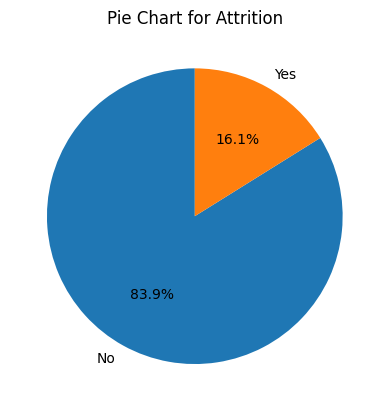

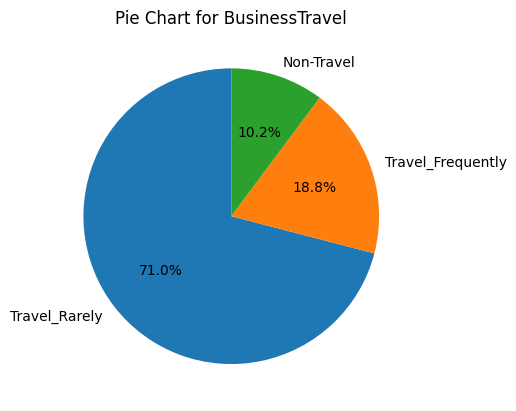

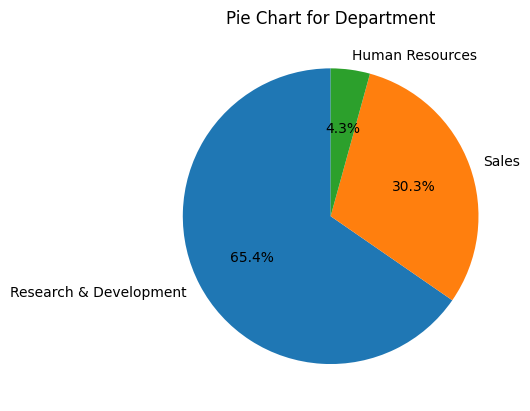

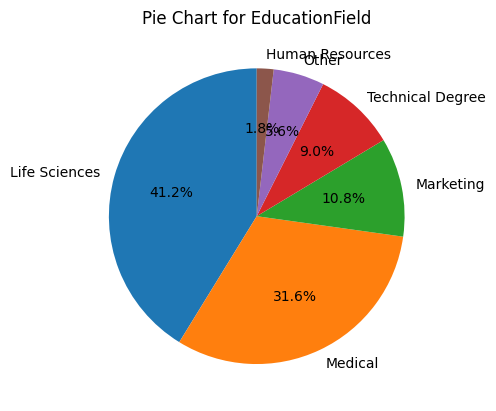

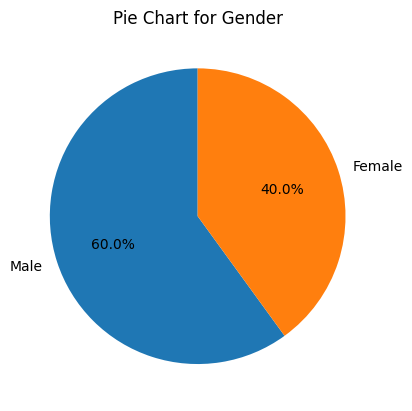

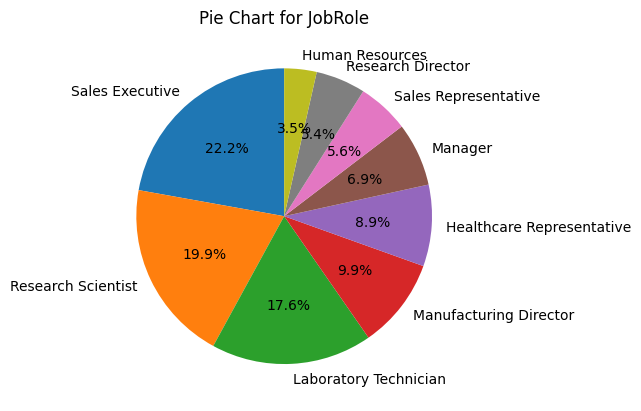

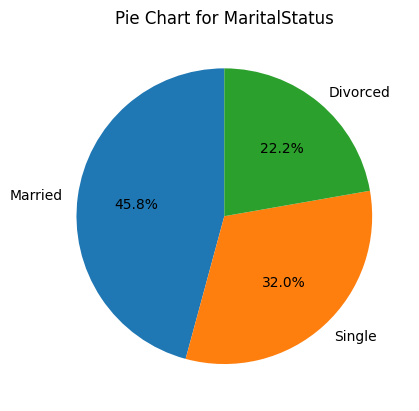

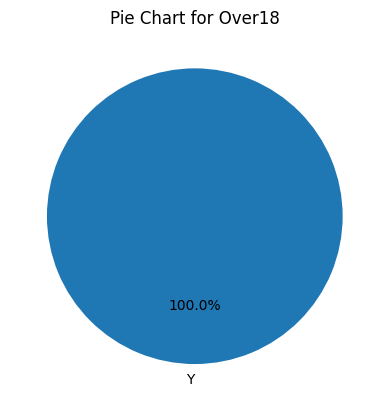

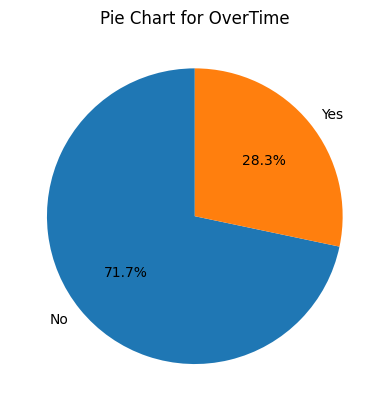

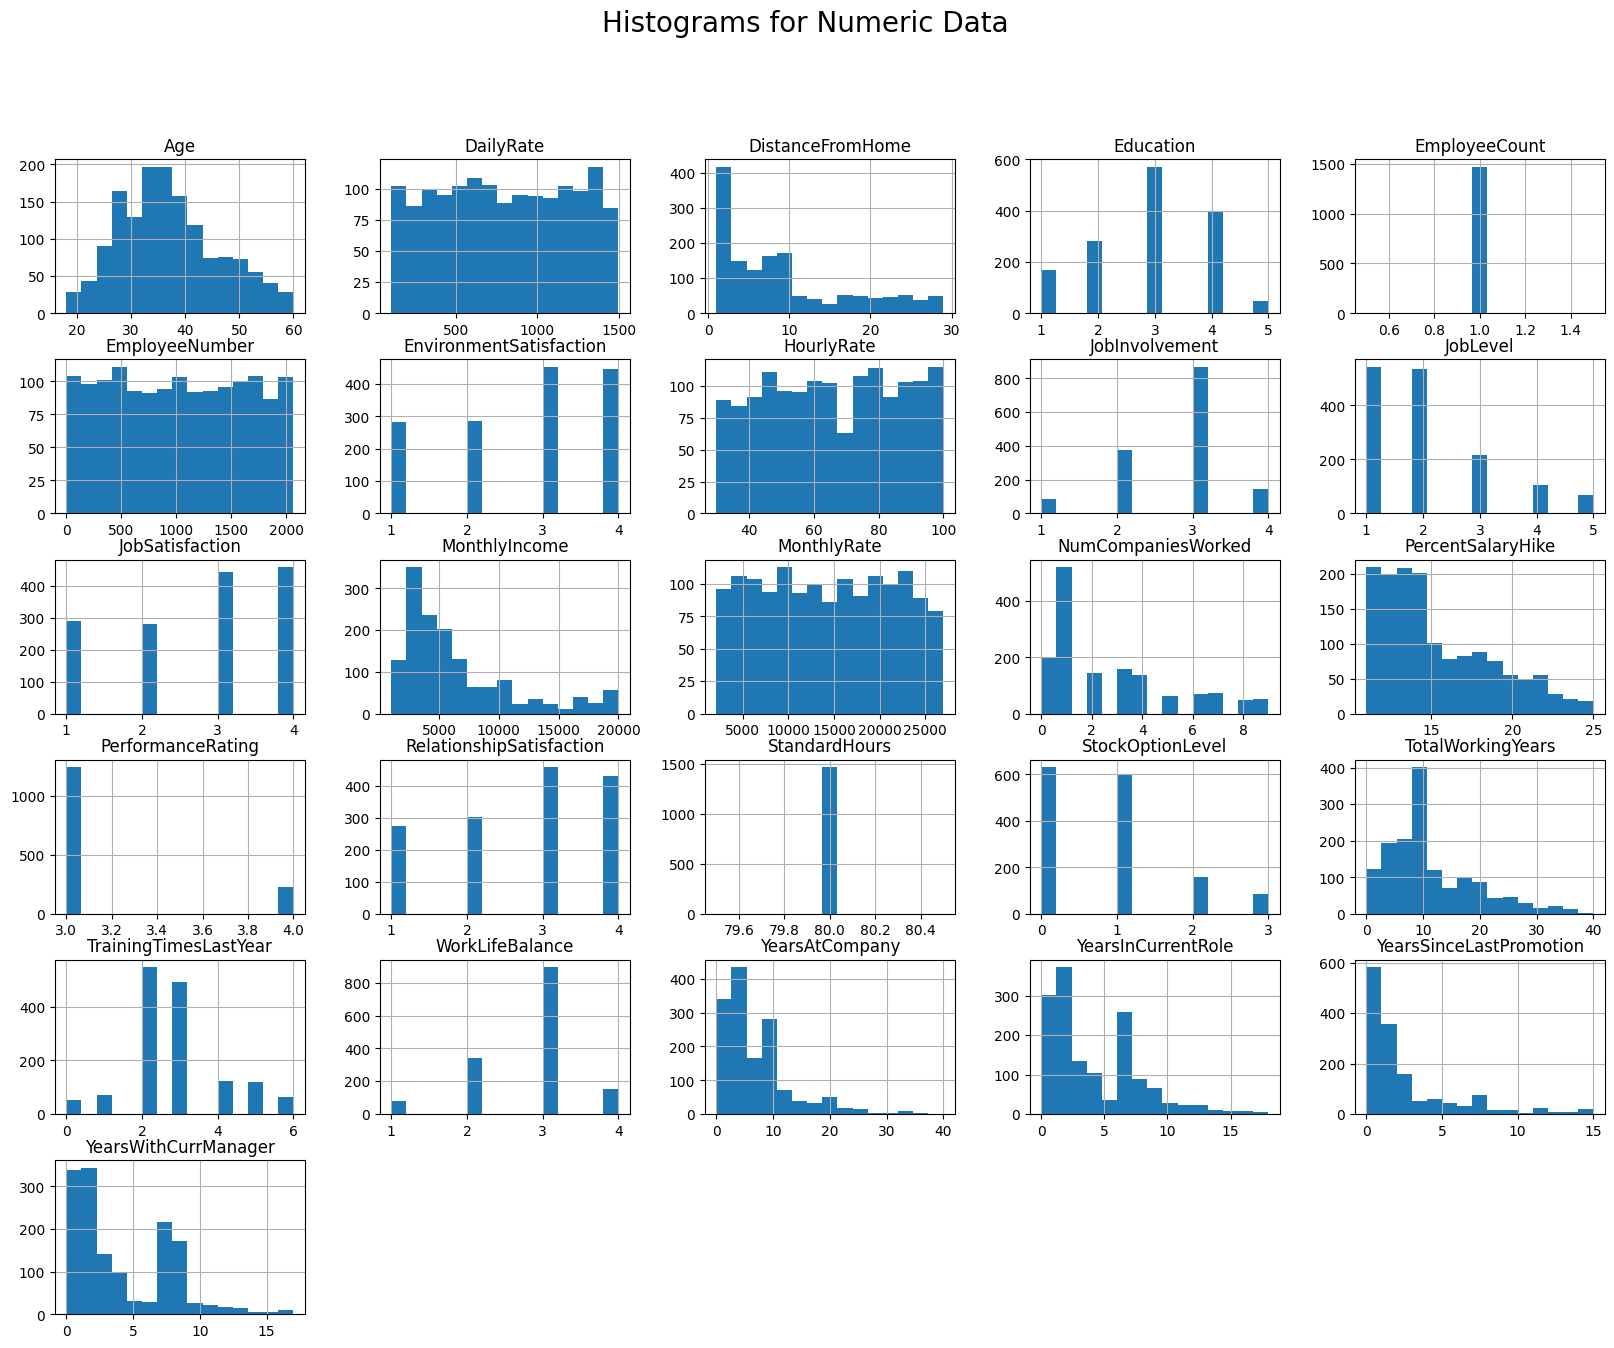

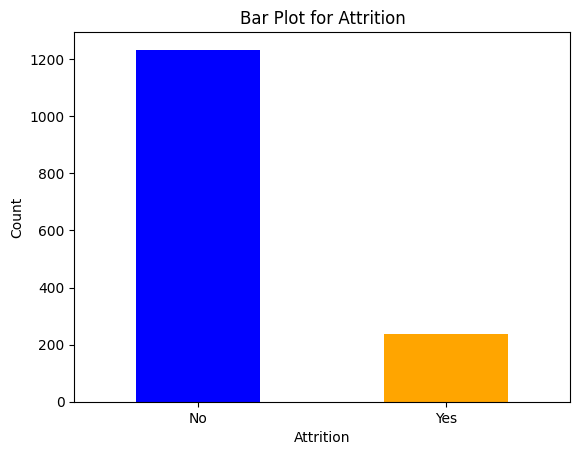

In [66]:
# Step 3: Generate pie charts for categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns

def plot_pie_charts(data, columns):
    for column in columns:
        data[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
        plt.title(f'Pie Chart for {column}')
        plt.ylabel('')
        plt.show()

plot_pie_charts(data, categorical_columns)

# Step 4: Generate histograms for numeric variables
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_columns].hist(bins=15, figsize=(20, 15))
plt.suptitle('Histograms for Numeric Data', fontsize=20)
plt.show()

# Step 5: Bar plot for the response variable "Attrition"
data['Attrition'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Bar Plot for Attrition')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

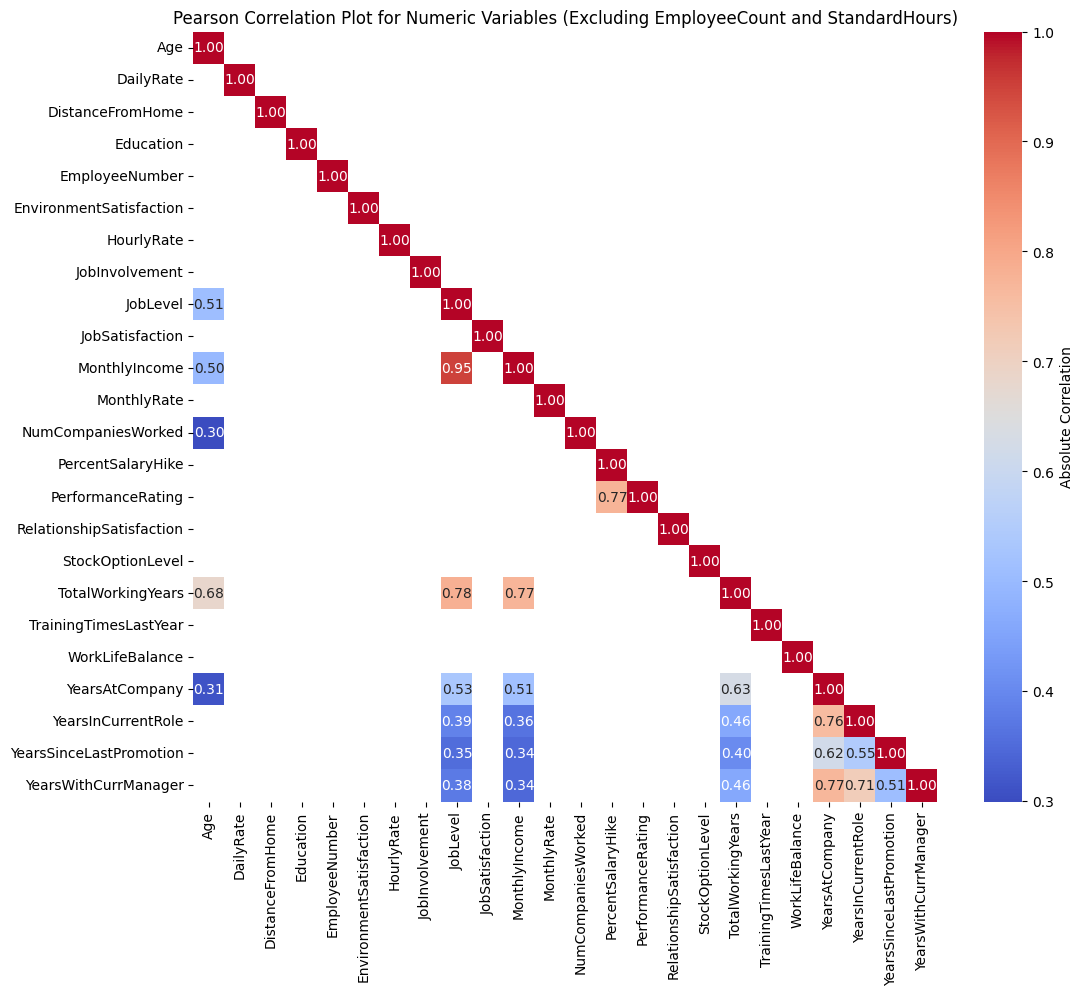

In [72]:
# Step 6: Pearson Correlation Plot for Numeric Variables (excluding 'EmployeeCount' and 'StandardHours')
# Define numeric columns excluding 'EmployeeCount' and 'StandardHours'
numeric_columns_filtered = numeric_columns.drop(['EmployeeCount', 'StandardHours'])

# Calculate the Pearson correlation matrix
corr_matrix = data[numeric_columns_filtered].corr(method='pearson').abs()

# Apply a mask to hide the upper triangle but keep the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1) | (corr_matrix < 0.25)

# Generate the Pearson Correlation Plot with filtered values
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, cbar_kws={"label": "Absolute Correlation"})
plt.title('Pearson Correlation Plot for Numeric Variables (Excluding EmployeeCount and StandardHours)')
plt.show()

In [76]:
categorical_columns = categorical_columns.drop(['Over18'])

Chi-Square Test Results:
                 Chi-square       p-value
OverTime         87.564294  8.158424e-21
JobRole          86.190254  2.752482e-15
MaritalStatus    46.163677  9.455511e-11
BusinessTravel   24.182414  5.608614e-06
Department       10.796007  4.525607e-03
EducationField   16.024674  6.773980e-03
Gender            1.116967  2.905724e-01
Feature: OverTime, p-value: 8.16e-21, Interpretation: There is a very strong association with Attrition.
Feature: JobRole, p-value: 2.75e-15, Interpretation: There is a very strong association with Attrition.
Feature: MaritalStatus, p-value: 9.46e-11, Interpretation: There is a very strong association with Attrition.
Feature: BusinessTravel, p-value: 5.61e-06, Interpretation: There is a very strong association with Attrition.
Feature: Department, p-value: 4.53e-03, Interpretation: There is a very strong association with Attrition.
Feature: EducationField, p-value: 6.77e-03, Interpretation: There is a very strong association with Attrition

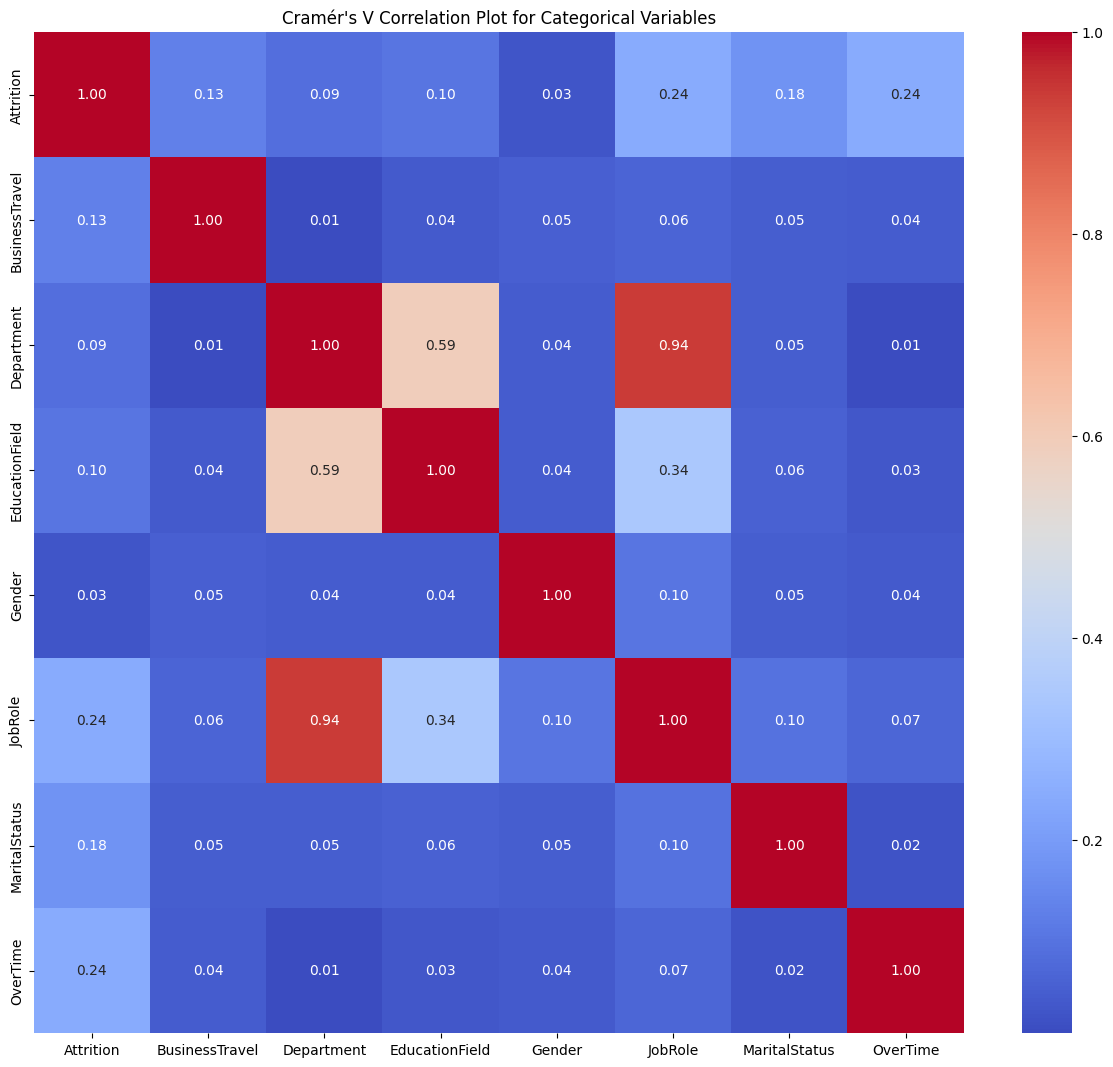

In [78]:
# Step 7: Chi-square test between categorical features and "Attrition"
def chi_square_test(data, target_column, categorical_columns):
    chi2_results = {}
    for column in categorical_columns:
        if column != target_column:
            contingency_table = pd.crosstab(data[column], data[target_column])
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            chi2_results[column] = {"Chi-square": chi2, "p-value": p}
    return pd.DataFrame(chi2_results).T

chi_square_results = chi_square_test(data, 'Attrition', categorical_columns)
chi_square_results.sort_values(by="p-value", inplace=True)
print("Chi-Square Test Results:\n", chi_square_results)

# P-value interpretation
for column in chi_square_results.index:
    p_value = chi_square_results.loc[column, 'p-value']
    if p_value < 0.01:
        interpretation = "very strong"
    elif p_value < 0.05:
        interpretation = "strong"
    else:
        interpretation = "no significant"

    print(f"Feature: {column}, p-value: {p_value:.2e}, Interpretation: There is a {interpretation} association with Attrition.")

# Step 8: Cramér's V Correlation Plot for Categorical Variables
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

categorical_corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            confusion_matrix = pd.crosstab(data[col1], data[col2])
            categorical_corr_matrix.loc[col1, col2] = cramers_v(confusion_matrix)
        else:
            categorical_corr_matrix.loc[col1, col2] = 1

categorical_corr_matrix = categorical_corr_matrix.astype(float)

plt.figure(figsize=(15, 13))
sns.heatmap(categorical_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cramér\'s V Correlation Plot for Categorical Variables')
plt.show()

Machine Learning Model Testing

We would use 3 models with no tuning to determine predictive potential

We could explore feature engineering (polynomials and interactions) and possibly more complex models (ANN) if needed.

Data is clearly imbalanced. Implementation of SMOTE or other under- and over-sampling tehcniques (if deemed useful) have to be done in training set only to avoid contamination of test set and sputious predictions.

In [79]:
# Step 9: Machine Learning Model Training and Evaluation
# Convert categorical variables to category codes
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define features and target variable
X = data.drop(columns=['Attrition', 'Over18', 'StandardHours', 'EmployeeCount'])
y = data['Attrition']

In [80]:
# Split the data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Initialize models with class_weight='balanced' where applicable
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier()  # Gradient Boosting does not support class_weight directly
}

c:\Users\Jose Guevara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.6599

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       255
           1       0.21      0.56      0.31        39

    accuracy                           0.66       294
   macro avg       0.56      0.62      0.54       294
weighted avg       0.82      0.66      0.71       294

Model: Decision Tree
Accuracy: 0.8095

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       255
           1       0.26      0.23      0.24        39

    accuracy                           0.81       294
   macro avg       0.57      0.56      0.57       294
weighted avg       0.80      0.81      0.81       294

Model: Random Forest
Accuracy: 0.8776

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       255
           1       0.80      0.10      0.18        39

    accuracy                           0.88       294
   ma

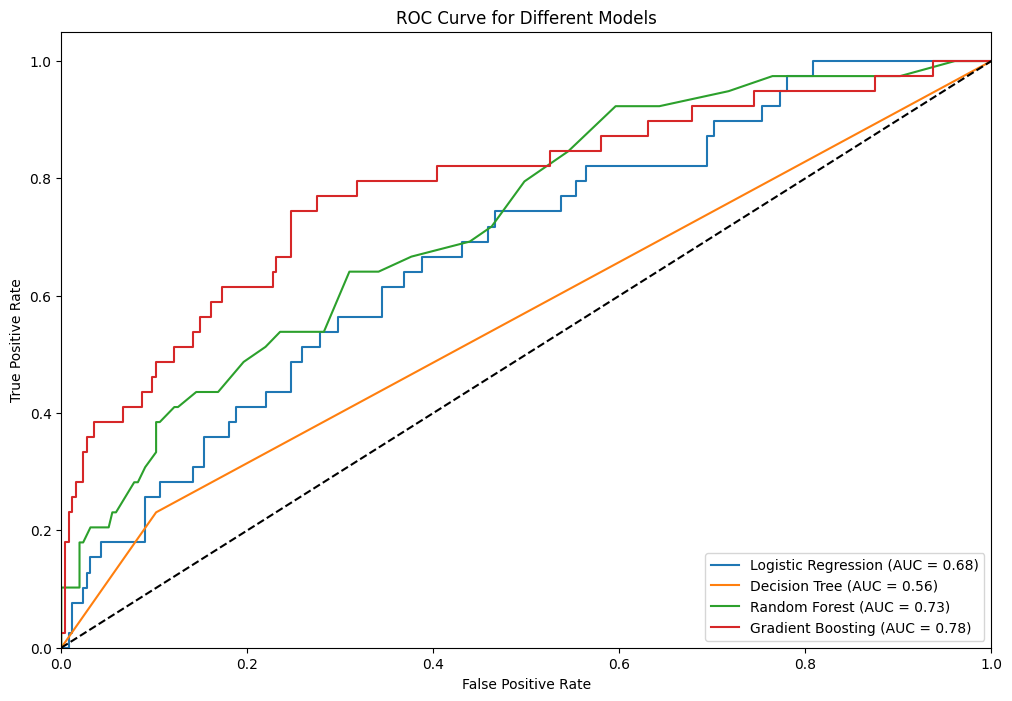

In [82]:
# Train and evaluate each model
plt.figure(figsize=(12, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {name}\nAccuracy: {accuracy:.4f}\n")
    print(classification_report(y_test, y_pred))
    print("="*60)

    # ROC curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.show()